# Tree-based Machine Learning and Feature Selection

This week we are learning about tree-based ML algorithms and how to select features for ML algorithms. Tree-based ML algorithms include:

- decision trees
- random forests
- boosting algorithms (e.g. xgboost, lightgbm, catboost)

The second topic we'll look at is selecting features. Some features will be more important for predicting the target than others, and we can use a few ways to select the best features:

- univariate statistics (like correlations)
- selection with ML algorithms (forward, backward, recursive selection)
- selection using feature importances from ML algorithms

We'll start with decision trees.

# Decision trees

In [108]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [109]:
df = pd.read_csv('data/prepped_diabetes_data.csv', index_col='Patient number')
df

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes,waist_hip_ratio,hdl_chol_ratio
Patient number,,,,,,,,,,,,,,,
1,193,77,49,19,1,61,119,22.5,118,70,32,38,0,0.842105,0.253886
2,146,79,41,19,1,60,135,26.4,108,58,33,40,0,0.825000,0.280822
3,217,75,54,20,1,67,187,29.3,110,72,40,45,0,0.888889,0.248848
4,226,97,70,20,1,64,114,19.6,122,64,31,39,0,0.794872,0.309735
5,164,91,67,20,1,70,141,20.2,122,86,32,39,0,0.820513,0.408537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,83,1,59,125,25.2,150,90,35,40,0,0.875000,0.193833
387,226,279,52,84,1,60,192,37.5,144,88,41,48,1,0.854167,0.230088
388,301,90,118,89,1,61,115,21.7,218,90,31,41,0,0.756098,0.392027


Let's create features and targets again, as well as train and test sets.

In [110]:
features = df.drop('Diabetes', axis=1)
targets = df['Diabetes']

x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=42)

Using the decision tree is similar to logistic regression in sklearn - we create the class, then use the fit method. It has the same score method (and other methods like predict).

In [111]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

1.0
0.8979591836734694


We can see the accuracy on the train set is perfect - 100%, but the test score is much lower at 87.7%. This is a classic sign of overfitting. We can see how deep the tree is and plot it like so:

In [112]:
dt.get_depth()

7

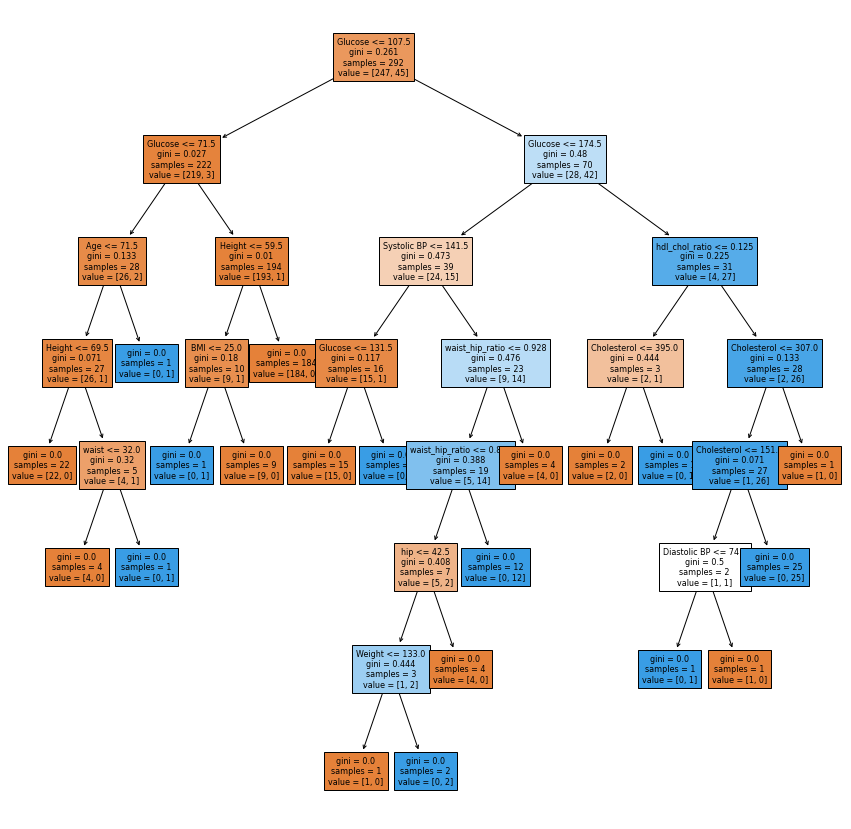

In [113]:
f = plt.figure(figsize=(15, 15))
_ = plot_tree(dt, fontsize=8, feature_names=features.columns, filled=True)

The plot shows us the nodes of the tree - the root node is at the top and leaf nodes are at the bottom. The color is blue for mostly class 1 and orange for mostly class 0. We can see most of the leaf nodes end up with pure samples of one or the other class, and some of the leaves only have 1 sample in them.

Seeing how deep the tree got and the number of samples in the leaf nodes is helpful. We can restrict the number of levels of splits with max_depth. You can try a few values below and see how it changes. Here, we settled on 2 since that results in nearly equal train/test scores and looks like it eliminates the overfitting.

In [114]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

0.9246575342465754
0.9285714285714286


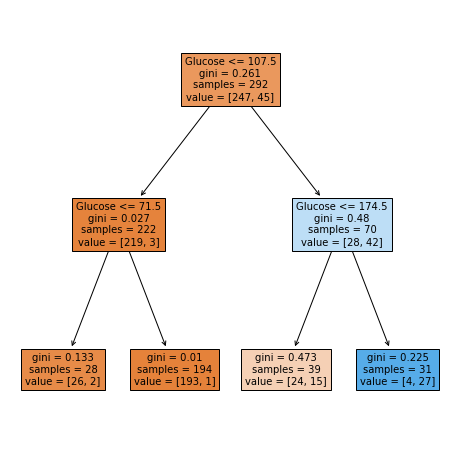

In [115]:
f = plt.figure(figsize=(8, 8))
_ = plot_tree(dt, fontsize=10, feature_names=features.columns, filled=True)

## Plotting decision trees

As we already saw, we can plot decision trees with sklearn's `sklearn.tree.plot_tree` function. Most arguments are self-explanatory and also laid out in the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html

# Random Forests

Random forests improve upon decision trees in a few ways:
- the algo uses many decision trees
- each decision tree is trained on a subset of data (bootstrapped or sampling with replacement from the original data)
- each DT uses a subset of features at each split

This can simultaneously reduce the bias and variance of the overall algorithm compared with decision trees (sometimes). We saw how easily decision trees can overfit to the data (high variance), so this is a good improvement. We can use this with sklearn like so:

In [116]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.9794520547945206
0.8979591836734694


Oops, looks like we are still overfitting. We can reduce the max depth a bit more to improve this. Try some different values and see what happens.

In [117]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.8972602739726028
0.8673469387755102


It looks like even with a low max depth, the random forest is still not outperforming the decision tree like we might have guessed. We can tune some other hyperparameters, like max_features. The default for this is the square root of the number of features, which is around 4. We can actually improve our performance a bit by tuning the max features and it looks like 7 is a good value:

In [118]:
import math

math.sqrt(x_train.shape[1])

3.7416573867739413

In [119]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, max_features=7, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.928082191780822
0.9387755102040817


To automatically tune these hyperparameters like max_features and max_depth, we can use hyperparameter search like [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [Bayesian search](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html). See the advanced section of week 3's FTE for an example of Bayesian search, or the sklearn documentation for examples of gridsearch.

# Feature selection

Feature selection is an important part of machine learning. If we don't have enough features, our ML algorithm may not perform well, but if we have too many features, the same thing can happen. The is a concept in machine learning and data science called "[the curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)". This states that as we have an increasing number of features, we need an exponentially increasing number of samples to cover the full sample space. One analogy is searching for a penny on a 100 meter line - we search down the line and find it eventually. If we change the line into a box (100m x 100m), then we have a much larger area to search. If we change this into a cube (100m ^3) then we have an exponentially increasing sample space to search. These dimensions are like our features.

A few ways to solve the curse of dimensionality problem are to get more data or remove some of our features. We can also reduce dimensions with dimensionality reduction techniques like principle component analysis (PCA) or singular value decomposition (SVD).

Here, we will focus on removing some features. The first way we'll look at are univariate statistics. These are stats between features and the target, such as correlation.

Second, we'll look at using feature importances from machine learning methods.

In the advanced section, we'll look at other methods with ML algos.

Let's start with the univariate stats method with Pearson correlation. 

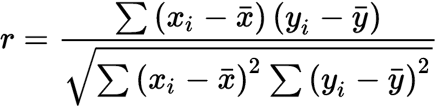

In [120]:
import seaborn as sns

<AxesSubplot:>

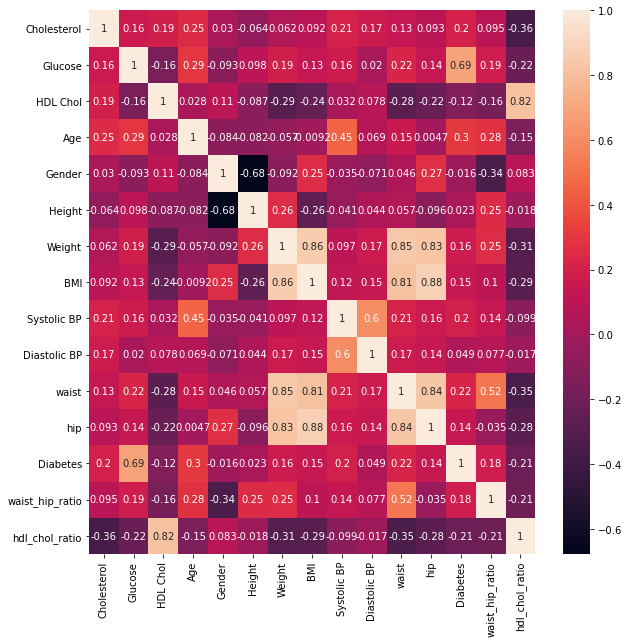

In [121]:
f = plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

This is called a correlogram, and plots the correlation of our dataframe matrix. By default, it uses the Pearson correlation, but there are some other correlations such as Kendall's Tau and Spearman. The Phik correlation has also been mentioned in week 1, and is in the advanced section here.

The `annot=True` argument shows the values in each square, making it a little easier to read and interpret.

Values close to 0 have no correlation, while +1 means perfect positive linear correlation and -1 means perfect inverse correlation (one variable goes up while the other goes down).

We can see from the correlogram that diastolic BP, height, and gender don't seem to be linear correlated to the target. However, there can be non-linear relationships too.

## Feature importances

For non-linear relationships between the feature and target, we can use feature importances from tree-based methods like decision trees and random forests. This method calculates the improvement in the Gini index or Entropy for each feature and ranks the features in order of which ones separate the classes best (see the slide deck for the week and/or [this article](https://quantdare.com/decision-trees-gini-vs-entropy/) for more on Gini/Entropy).

We can plot feature importances the hard way (such as [this](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)), or we can use a [pre-built function](https://scikit-plot.readthedocs.io/en/stable/estimators.html#scikitplot.estimators.plot_feature_importances) from scikit-plot. First, you will need to install sckit-plot with `conda install -c conda-forge scikit-plot -y` or `pip install scikit-plot`.

<AxesSubplot:title={'center':'Feature Importance'}>

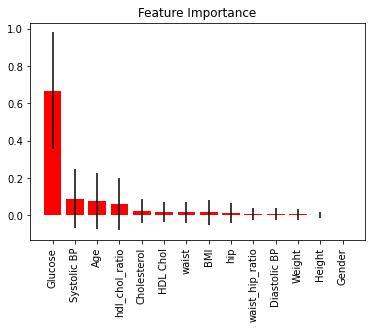

In [122]:
from scikitplot.estimators import plot_feature_importances

plot_feature_importances(rfc, feature_names=features.columns, x_tick_rotation=90)

We can see here that Glucose seems to be the most important variable, with a sharp dropoff in importance after that. We can remove some of the less-important features and see how that changes performance and the feature importance.

In [123]:
new_features = features.drop(['waist_hip_ratio', 'Diastolic BP', 'Weight', 'Height', 'Gender'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(new_features, targets, stratify=targets, random_state=42)

In [124]:
rfc = RandomForestClassifier(max_depth=2, max_features=7, random_state=42)
rfc.fit(x_train, y_train)

print(rfc.score(x_train, y_train))
print(rfc.score(x_test, y_test))

0.934931506849315
0.9285714285714286


<AxesSubplot:title={'center':'Feature Importance'}>

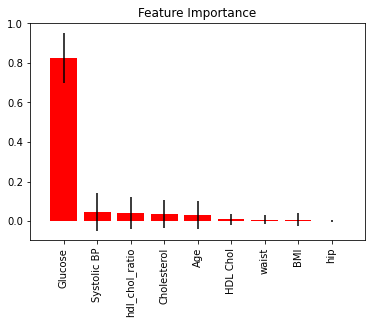

In [126]:
plot_feature_importances(rfc, feature_names=new_features.columns, x_tick_rotation=90)

It doesn't look like our performance changed much at all, but our feature importances did. However, one thing is clear - the glucose measurement seems to be very important for predicting diabetes risk.

These feature importance methods are good as EDA as well. If we have a target variable or want to see the relationship between variables that may be non-linear, decision tree or random forest feature importances are a great option.

# (Optional) Advanced Section

- H2O random forests and feature importances
- forward/backward feature selection
- recursive feature selection
- phik correlations
- other univariate statistics

We will demo H2O and phik here. For other feature selection methods, the [sklearn documentation](https://scikit-learn.org/stable/modules/feature_selection.html) has examples.

## H2O random forests
H2O is another machine learning library available in Python and R. It can scale up to clusters for big data. Luckly, it's easily installed with conda: `conda install -c conda-forge h2o-py -y`. When installing with pip, you also need to install a particular version of Java and potentially some other configuration issue. Conda makes it easy.

Once we have it installed, we import it and initialize it. The initialization starts up the backend of H2O (which is running on Java).

In [72]:
import h2o

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 15+36-1562, mixed mode, sharing)
  Starting server from C:\Users\words\anaconda3\envs\msds\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\words\AppData\Local\Temp\tmp0mbnuwtn
  JVM stdout: C:\Users\words\AppData\Local\Temp\tmp0mbnuwtn\h2o_words_started_from_python.out
  JVM stderr: C:\Users\words\AppData\Local\Temp\tmp0mbnuwtn\h2o_words_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Denver
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_words_91vnnt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.977 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


H2O has some impressive advantages over sklearn:
- it can handle missing values and categorical values without modification (sklearn needs all numeric values and no missing values)
- it can scale to big data easily (although `sklearn` can scale with the `dask` package)
- it has some other conveniences not built-in to sklearn, like plotting feature importances
- it has automatic ML capabilities

However, the H2O Python documentation is not nearly as good as sklearn.

To use H2O, we have to use a different data storage - an h2oframe. We will load our original, unmodified data here:

In [76]:
hf = h2o.H2OFrame(pd.read_excel('data/diabetes_data.xlsx', index_col='Patient number'))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [77]:
hf

Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes
193,77,49,19,female,61,119,22.5,118,70,32,38,No diabetes
146,79,41,19,female,60,135,26.4,108,58,33,40,No diabetes
217,75,54,20,female,67,187,29.3,110,72,40,45,No diabetes
226,97,70,20,female,64,114,19.6,122,64,31,39,No diabetes
164,91,67,20,female,70,141,20.2,122,86,32,39,No diabetes
170,69,64,20,female,64,161,27.6,108,70,37,40,No diabetes
149,77,49,20,female,62,115,21,105,82,31,37,No diabetes
164,71,63,20,male,72,145,19.7,108,78,29,36,No diabetes
230,112,64,20,male,67,159,24.9,100,90,31,39,No diabetes
179,105,60,20,female,58,170,35.5,140,100,34,46,No diabetes


In [94]:
hf.types

{'Cholesterol': 'int',
 'Glucose': 'int',
 'HDL Chol': 'int',
 'Age': 'int',
 'Gender': 'enum',
 'Height': 'int',
 'Weight': 'int',
 'BMI': 'real',
 'Systolic BP': 'int',
 'Diastolic BP': 'int',
 'waist': 'int',
 'hip': 'int',
 'Diabetes': 'enum'}

Then, we can use H2O to fit a random forest. There are examples in the documentation on how to do this: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

as well as an example for tuning hyperparameters: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html

In [95]:
from h2o.estimators import H2ORandomForestEstimator

predictors = hf.columns
predictors.remove('Diabetes')
response = 'Diabetes'

# Split the dataset into a train and valid set:
train, valid = hf.split_frame(ratios=[.8], seed=1234, )

# Build and train the model:
drf = H2ORandomForestEstimator(ntrees=50,
                                    max_depth=2,
                                    calibrate_model=True,
                                    calibration_frame=valid)
drf.train(x=predictors,
           y=response,
           training_frame=train,
           validation_frame=valid)

# Eval performance:
perf = drf.model_performance(valid=valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


The performance metrics are easy to access:

In [96]:
perf


ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.11488715040426772
RMSE: 0.33895007066567745
LogLoss: 0.36313712672486653
Mean Per-Class Error: 0.0839080459770114
AUC: 0.9109195402298851
AUCPR: 0.9531710698235958
Gini: 0.8218390804597702

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7450278670713306: 


,,Diabetes,No diabetes,Error,Rate
0,Diabetes,12.0,3.0,0.2,(3.0/15.0)
1,No diabetes,0.0,58.0,0.0,(0.0/58.0)
2,Total,12.0,61.0,0.0411,(3.0/73.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.745028,0.974790,54.0
1,max f2,0.745028,0.989761,54.0
2,max f0point5,0.802050,0.965517,51.0
3,max accuracy,0.745028,0.958904,54.0
4,max precision,0.983197,1.000000,0.0
5,max recall,0.745028,1.000000,54.0
6,max specificity,0.983197,1.000000,0.0
7,max absolute_mcc,0.745028,0.872156,54.0
8,max min_per_class_accuracy,0.834864,0.866667,46.0
9,max mean_per_class_accuracy,0.802050,0.916092,51.0



Gains/Lift Table: Avg response rate: 79.45 %, avg score: 86.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.041096,0.983197,1.258621,1.258621,1.000000,0.983197,1.000000,0.983197,0.051724,0.051724,25.862069,25.862069,0.051724
1,2,0.041096,0.983069,0.000000,1.258621,0.000000,0.000000,1.000000,0.983197,0.000000,0.051724,-100.000000,25.862069,0.051724
2,3,0.041096,0.982493,0.000000,1.258621,0.000000,0.000000,1.000000,0.983197,0.000000,0.051724,-100.000000,25.862069,0.051724
3,4,0.054795,0.979160,1.258621,1.258621,1.000000,0.982397,1.000000,0.982997,0.017241,0.068966,25.862069,25.862069,0.068966
4,5,0.109589,0.969117,0.943966,1.101293,0.750000,0.972669,0.875000,0.977833,0.051724,0.120690,-5.603448,10.129310,0.054023
5,6,0.150685,0.961717,1.258621,1.144201,1.000000,0.964877,0.909091,0.974300,0.051724,0.172414,25.862069,14.420063,0.105747
6,7,0.205479,0.951624,1.258621,1.174713,1.000000,0.955895,0.933333,0.969392,0.068966,0.241379,25.862069,17.471264,0.174713
7,8,0.301370,0.938641,1.258621,1.201411,1.000000,0.945924,0.954545,0.961925,0.120690,0.362069,25.862069,20.141066,0.295402
8,9,0.397260,0.918333,1.258621,1.215220,1.000000,0.928350,0.965517,0.953820,0.120690,0.482759,25.862069,21.521998,0.416092
9,10,0.506849,0.894348,1.101293,1.190587,0.875000,0.908261,0.945946,0.943970,0.120690,0.603448,10.129310,19.058714,0.470115


Plotting the variable (feature) importance is a built-in function. We need to set the num_of_features to our actual number of features to show them all if it's greater than 10.

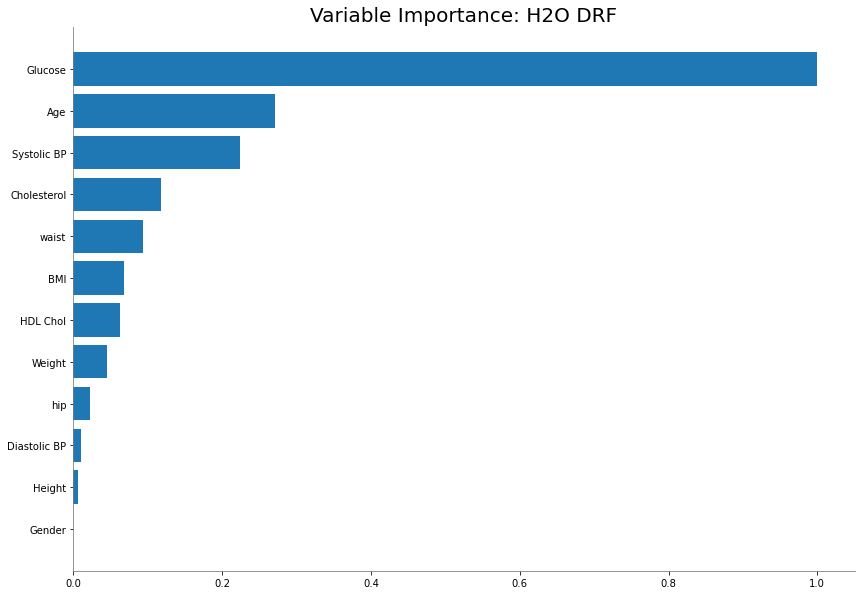

In [102]:
drf.varimp_plot(num_of_features=features.shape[1])

## Phi-k correlations

The phi-k correlation is a newer one (invented around 2018), and can be read more about in the [docs](https://phik.readthedocs.io/en/latest/) and their publication linked there. Essentially, it bins numeric data into categories and then uses the chi-2 correlation. We can install it with `conda install -c conda-forge phik -y` then import it. Then we have the `phik_matrix()` method for dataframes available:

In [97]:
import phik

df.phik_matrix()

interval columns not set, guessing: ['Cholesterol', 'Glucose', 'HDL Chol', 'Age', 'Gender', 'Height', 'Weight', 'BMI', 'Systolic BP', 'Diastolic BP', 'waist', 'hip', 'Diabetes', 'waist_hip_ratio', 'hdl_chol_ratio']


,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes,waist_hip_ratio,hdl_chol_ratio
Cholesterol,1.000000,0.446082,0.659471,0.283181,0.000000,0.000000,0.157181,0.000000,0.084602,0.413111,0.165225,0.000000,0.273944,0.000000,0.454436
Glucose,0.446082,1.000000,0.374987,0.288084,0.129810,0.000000,0.377673,0.000000,0.123225,0.000000,0.341367,0.278049,0.892266,0.260712,0.282767
HDL Chol,0.659471,0.374987,1.000000,0.528813,0.344375,0.291129,0.345003,0.199632,0.220515,0.285706,0.213384,0.135621,0.218219,0.272280,0.705109
Age,0.283181,0.288084,0.528813,1.000000,0.093540,0.242935,0.000000,0.158348,0.570891,0.282859,0.213992,0.000000,0.406654,0.277961,0.366156
Gender,0.000000,0.129810,0.344375,0.093540,1.000000,0.891253,0.239513,0.320331,0.097494,0.050717,0.089918,0.355619,0.000000,0.435635,0.117529
Height,0.000000,0.000000,0.291129,0.242935,0.891253,1.000000,0.246358,0.490367,0.182323,0.000000,0.000000,0.195724,0.000000,0.260534,0.000000
Weight,0.157181,0.377673,0.345003,0.000000,0.239513,0.246358,1.000000,0.884083,0.000000,0.237686,0.842356,0.828146,0.228043,0.414019,0.248324
BMI,0.000000,0.000000,0.199632,0.158348,0.320331,0.490367,0.884083,1.000000,0.127813,0.122860,0.835016,0.890428,0.194729,0.168507,0.188440
Systolic BP,0.084602,0.123225,0.220515,0.570891,0.097494,0.182323,0.000000,0.127813,1.000000,0.640785,0.178338,0.225762,0.279749,0.000000,0.000000
Diastolic BP,0.413111,0.000000,0.285706,0.282859,0.050717,0.000000,0.237686,0.122860,0.640785,1.000000,0.122098,0.156181,0.068323,0.000000,0.000000


We can also create a correlogram:

interval columns not set, guessing: ['Cholesterol', 'Glucose', 'HDL Chol', 'Age', 'Gender', 'Height', 'Weight', 'BMI', 'Systolic BP', 'Diastolic BP', 'waist', 'hip', 'Diabetes', 'waist_hip_ratio', 'hdl_chol_ratio']


<AxesSubplot:>

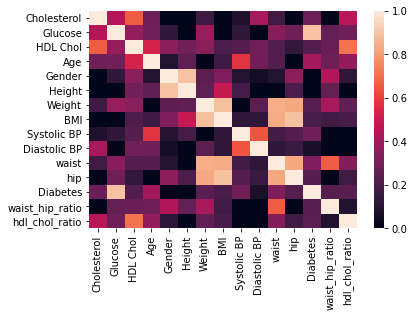

In [99]:
sns.heatmap(df.phik_matrix())

The values range from 0 (no correlation) to 1 (perfect correlation), but we don't get information on the direction of the correlation. We do get correlation measurements for non-linear relationships, though. Here, we can see that gender and height seem to have the lowest correlation strengths (near 0), which agrees with the random forest importances.